## Sistema de predicción eólica sencillo

En este notebook, procedo a extraer, transformar y cargar los datos en un sistema de predicción que desarrollaremos paso a paso.
En primer lugar, importamos las librerías necesarias para trabajar.

In [1]:
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Una vez cargamos los datos, partimos el conjunto en dos dataframes distintos y renombramos ciertas variables para poder trabajar más cómodamente. También transformamos los datos 'observaciones' a datetime.

In [2]:
data = pd.read_fwf('Meteologica_vacante_ProgPredR_ProblemaDatos_20190910.txt', parse_dates=['observaciones'])
split = data.loc[data['observaciones'] == 'predicciones'].index.values.astype(int)[0]
df_observation = data[:split]
df_prediction = data[split+1:]

In [3]:
df_observation[['production','wind_mod']] = df_observation['Unnamed: 1'].str.split(" ",expand=True)
df_observation = df_observation[[x for x in df_observation.columns if x != 'Unnamed: 1']]
df_predict = df_prediction.rename(columns={'Unnamed: 1': 'wind_mod'})

In [4]:
df_observation['production'] = pd.to_numeric(df_observation['production'])
df_observation['wind_mod'] = pd.to_numeric(df_observation['wind_mod'])
df_predict['wind_mod'] = pd.to_numeric(df_predict['wind_mod'])

In [5]:
df_observation['observaciones'] = pd.to_datetime(df_observation['observaciones'], errors='coerce', format='%Y-%m-%d %H:%M')
df_predict['observaciones'] = pd.to_datetime(df_predict['observaciones'], errors='coerce', format='%Y-%m-%d %H:%M')

In [6]:
df_observation['wind_mod'] = df_observation.wind_mod.astype(int)
df_observation['production'] = df_observation.production.astype(int)
df_predict['wind_mod'] = df_predict.wind_mod.astype(int)

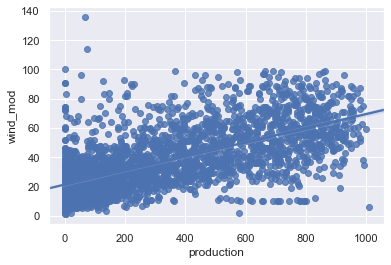

In [7]:
ax = sns.regplot(x="production", y="wind_mod", data=df_observation)

En la siguiente celda, definimos los errores que emplearemos másadelante.

In [8]:

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))

def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

Definimos las variables:

- L este parámetro corresponderá a la potencia instalada del parque, cómo no disponemos del dato de potencia instalada, utilizaremos el valor máximo de los datos de producción.
- k y x0 para estos dos parámetros dividiremos el espacio de búsqueda de la siguiente forma:
    - x0 estará comprendido entre 0 y el valor máximo de modulo de viento presente en los datos y dividiremos este intervalo en 20 trozos
    - k utilizaremos el intervalo [ 12 , 2 3 ] y probaremos cada valor separado 0,05

In [9]:
wind_mod = list(map(int, list(df_observation['wind_mod'])))
production = list(map(int, list(df_observation['production'])))
wind_mod_pred = list(map(int, list(df_predict['wind_mod'])))

L = float(max(wind_mod))
k = (np.arange(0.5,1.5,0.05)).tolist()
x0 = (np.linspace(start=0, stop=L, num=20)).tolist()

Definiomos la función train para recorrer todos los elementos de los arrays definidos y obtener los valores de los MAE, MSE y RMSE

In [10]:
def to_train(wind_mod, L, k, x0):   
    result = []
    parameters = []
    mse_err = []
    mae_err = []
    rmse_err = []
    for x in wind_mod:
        for i in k:
            for s in x0:

                try:
                    func = L/(1-math.exp(-(i)*((x)-(s))))
                    params = [i, s]

                    if func > 0: # He puesto esta condición porque previamente me salían valores negativos
                        result.append(func)
                        parameters.append(params)

                        # Defino dos arrays para cálculo de errores
                        actual_array = np.asarray(func, dtype=np.float32)
                        predicted_array = np.asarray(wind_mod_pred, dtype=np.float32)

                        mse_err.append(mse(actual_array, predicted_array))
                        mae_err.append(mae(actual_array, predicted_array))
                        rmse_err.append(rmse(actual_array, predicted_array))

                except ZeroDivisionError:
                    continue
    return parameters, mse_err, mae_err, rmse_err

In [11]:
parameters, mse_err, mae_err, rmse_err = to_train(wind_mod, L, k, x0)

In [12]:
print('Valor de RMSE mínimo: ',np.amin(rmse_err))
print('Valor de MSE mínimo: ',np.amin(mse_err))
print('Valor de MAE mínimo: ',np.amin(mae_err))

print('Parámetros optimizados para el RMSE: ',parameters[(int(np.argmin(rmse_err)))])

Valor de RMSE mínimo:  97.65098
Valor de MSE mínimo:  9535.714
Valor de MAE mínimo:  94.57143
Parámetros optimizados para el RMSE:  [0.5, 0.0]


En esta otra función, empleamos los valores optimizados para realizar nuestra predicción.

In [13]:
params = parameters
def to_fit(wind_mod_pred, params, mse_err, mae_err, rmse_err):    
    rmse_best_k = parameters[(int(np.argmin(rmse_err)))][0]
    rmse_best_x0 = parameters[(int(np.argmin(rmse_err)))][1]

    mse_best_k = parameters[(int(np.argmin(mse_err)))][0]
    mse_best_x0 = parameters[(int(np.argmin(mse_err)))][1]

    mae_best_k = parameters[(int(np.argmin(mae_err)))][0]
    mae_best_x0 = parameters[(int(np.argmin(mae_err)))][1]

    rmse_output = (int(np.amin(rmse_err)))/100
    mse_output = (int(np.amin(mse_err)))/100
    mae_output = (int(np.amin(mae_err)))/100
    
    wind_mod_pred_rmse = []
    wind_mod_pred_mse = []
    wind_mod_pred_mae = []


    for x in wind_mod_pred:
        funcion_params_rmse = L/(1-math.exp(-(rmse_best_k)*((x)-rmse_best_x0)))
        funcion_params_mse = L/(1-math.exp(-(mse_best_k)*((x)-mse_best_x0)))
        funcion_params_mae = L/(1-math.exp(-(mae_best_k)*((x)-mae_best_x0)))

        wind_mod_pred_rmse.append(funcion_params_rmse)
        wind_mod_pred_mse.append(funcion_params_mse)
        wind_mod_pred_mae.append(funcion_params_mae)    

    print(L , rmse_best_k, rmse_best_x0)
    print(mae_output, rmse_output)
    return wind_mod_pred_rmse

In [14]:
wind_module = to_fit(wind_mod_pred, params, mse_err, mae_err, rmse_err)

136.0 0.5 0.0
0.94 0.97


In [15]:
df_predict["production"] = [ '%.2f' % elem for elem in wind_module ]

El output final tras el proceso de cálculo es el siguiente

In [17]:
to_fit(wind_mod_pred, params, mse_err, mae_err, rmse_err)
print(df_predict[["observaciones","production"]].to_string(index=False))

136.0 0.5 0.0
0.94 0.97
      observaciones production
2009-11-12 00:00:00     136.00
2009-11-15 03:00:00     136.00
2009-11-12 06:00:00     136.00
2009-11-12 09:00:00     136.00
2009-11-16 12:00:00     136.00
2009-11-28 18:00:00     136.01
2009-11-13 00:00:00     157.29


Al representar los valores predichos, nos encontramos con que, para un intervalo de confianza del 90% no son óptimos. Para mejorar el modelo podría emplear librerías con funciones de regresión optimizadas que proporcionen mejor resultado.

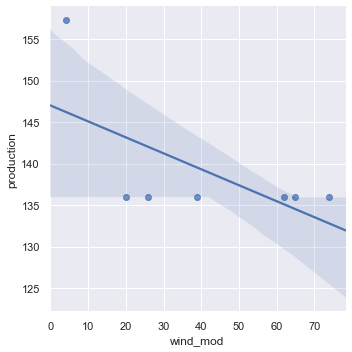

In [18]:
df_predict['production'] = pd.to_numeric(df_predict['production'])
df_predict['wind_mod'] = pd.to_numeric(df_predict['wind_mod'])

ay = sns.lmplot(x="wind_mod", y="production", data=df_predict, ci=90)